# 기계 학습 입문: Heart Disease 자료

## creators: 경상대학교 정보통계학과 전산통계실험실 조종권, 현태진 ([원본](https://github.com/JJongKwon/Seminar/blob/master/Heart%20Disease.ipynb))

## reviewed, modified, and edited by 박중양

## Objective of the notebook

기계 학습 예제 데이터들을 모아둔 사이트 [UCI Machine Learning Repository: Data Sets](https://archive.ics.uci.edu/ml/datasets.html)에서 Heart Disease dataset를 분석하여 심장병 유무를 진단하는 기계 학습 모형을 만들고자 한다.

* 사용할 패키지: sklearn
* 사용할 알고리즘: SVM(support vector machine)에 기반한 분류 알고리즘(SVC)

## Heart Disease 자료


자료를 분석하는 첫 단계는 자료를 이해하는 것이다.
자료를 이해한다는 것은 자료의 출처, 자료를 수집한 목적, 자료를 구성하는 변수(특징, variable, feature)의 측정법, 척도, 단위, 측정하는 목적 등을 알아보는 것을 의미한다.


Heart Disease의 원 자료는 총 76개의 변수들로 이루어져 있으나, 대부분의 기계 학습 실습은 303명에서 측정한 14개 변수로 이루어진 Cleveland database를 이용한다.
이 노트에서도 Cleveland database를 사용한다.

데이터 출처:
* https://www.kaggle.com/ronitf/heart-disease-uci
* https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
heart = pd.read_csv("https://raw.githubusercontent.com/taejinhyun/sklearn_models/master/Heart%20Disease/heart.csv")

## 자료에 대한 이해

자료에 대한 자세한 사항은 **서성효**가 작성한 [문서](https://github.com/sung-hyo/sklearn_study/blob/master/Heart%20data%20description.ipynb)를 참조한다.



In [3]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## 데이터 탐색

결측치가 있는지 확인한다.

In [4]:
heart.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

각 특징이 어떤 값을 가지는지 확인하여 특징의 설명과 일치하는지 확인할 필요가 있다.

In [5]:
heart.slope.unique()

array([0, 2, 1])

In [6]:
heart.ca.unique()

array([0, 2, 1, 3, 4])

`ca` 특징의 설명에 의하면 4는 값은 `unknown`이다,
이는 일종의 결측치에 해당한다.
따라서 `ca` 특징이 4인 행은 제거한다.

In [0]:
heart = heart[heart.ca != 4]

In [8]:
# 데이터에 대한 정보
heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 302
Data columns (total 14 columns):
age         298 non-null int64
sex         298 non-null int64
cp          298 non-null int64
trestbps    298 non-null int64
chol        298 non-null int64
fbs         298 non-null int64
restecg     298 non-null int64
thalach     298 non-null int64
exang       298 non-null int64
oldpeak     298 non-null float64
slope       298 non-null int64
ca          298 non-null int64
thal        298 non-null int64
target      298 non-null int64
dtypes: float64(1), int64(13)
memory usage: 34.9 KB


## 범주형 특징을 처리한다.

`sex`,`cp`, `restecg`, `exang`, `slope`, `thal`, `ca`, `fbs`는 명목 또는 순서 척도를 갖는 범주형 특징이고 나머지는 구간 또는 비 척도를 갖는 특징들이다.
자료를 제대로 처리하기 위해서는 범주형 특징이 범주형임을 지정해야 한다.

In [0]:
categoricals = ['sex','cp','restecg','exang','slope','thal', 'ca', 'fbs']
numerics = ['age','trestbps','chol','thalach','oldpeak']

In [0]:
for feature in categoricals:
    heart[feature]=pd.Categorical(heart[feature])

In [11]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 302
Data columns (total 14 columns):
age         298 non-null int64
sex         298 non-null category
cp          298 non-null category
trestbps    298 non-null int64
chol        298 non-null int64
fbs         298 non-null category
restecg     298 non-null category
thalach     298 non-null int64
exang       298 non-null category
oldpeak     298 non-null float64
slope       298 non-null category
ca          298 non-null category
thal        298 non-null category
target      298 non-null int64
dtypes: category(8), float64(1), int64(5)
memory usage: 19.7 KB


### target에 대한 탐색

In [12]:
#target 변수의 상대도수를 확인
freq = heart.target.value_counts(normalize=True)
print(freq)

1    0.540268
0    0.459732
Name: target, dtype: float64


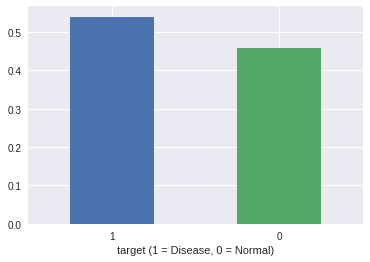

In [13]:
freq.plot(kind='bar')
plt.xlabel("target (1 = Disease, 0 = Normal)")
plt.xticks(rotation=0)
plt.show()

## 대상(target)과 특징의 관계 탐색

모형을 만든다는 것은 특징과 대상(target) 간의 관계를 찾아낸다는 것을 의미한다.
따라서 특징과 대상이 연관을 가지는를 확인하는 것은 중요하다.
이 탬색은 중요한 특징을 선별하거나 새로운 특징을 만드는 특징 공학에 필요한 정보를 제공한다.

* 범주형 특징과 범주형 대상의 연관은 교차표와 막대그림표를 작성하여 알아볼 수 있다.
* 범주형 특징과 양적 대상의 연관은 범주형 특징의 각 값별로 양적 대상의 평균, 표준편차 등을 계산하여 분포가 같은지를 검토하여 알아볼 수 있다.
* 양적 특징과 양적 대상의 연관은 산점도와 상관 계수 등을 통해서 확인한다.


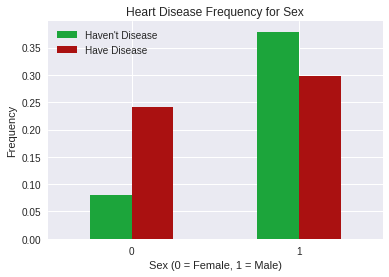

In [14]:
# 성별에 따른 target(심장병 여부)의 교차표를 통한 상대도수 그래프
pd.crosstab(heart.sex, heart.target, normalize='all').plot(kind="bar", color=['#1CA53B','#AA1111'])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

## 특징과 대상을 분리한다. (선택 사항)

In [0]:
y = heart.target
X = heart.drop(columns = ['target'], axis = 1)

## 범주형 특징을 one-hot encoding한다.

In [0]:
X = pd.get_dummies(X)

In [17]:
X.head()

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_0,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
2,41,130,204,172,1.4,1,0,0,1,0,...,0,1,1,0,0,0,0,0,1,0
3,56,120,236,178,0.8,0,1,0,1,0,...,0,1,1,0,0,0,0,0,1,0
4,57,120,354,163,0.6,1,0,1,0,0,...,0,1,1,0,0,0,0,0,1,0


## 훈련 자료와 테스트 자료로 나눈다.

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, random_state=20181212)

## 양적 변수를 정규화한다.

정규화 또는 표준화는 훈련 자료와 테스트 자료로 나눈 다음 실시한다.
전체 자료에 대해서 정규화나 표준화를 하고 나서 훈련 자료와 테스트 자료로 나누면 이미 테스트 자료의 정보 일부가 표준화나 정규화에 사용되었다는 의미를 가지게 되므로 피해야 한다.

In [0]:
X_tr_cat = X_tr.drop(numerics, axis=1)
X_tr_num = X_tr[numerics]

X_ts_cat = X_ts.drop(numerics, axis=1)
X_ts_num = X_ts[numerics]

In [20]:
X_tr_cat.index

Int64Index([ 99,  94,  49, 293,  53, 166, 268, 266, 117, 195,
            ...
            206, 263,  50, 143, 258, 142,  18,   1, 182,  65],
           dtype='int64', length=223)

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(X_tr_num)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
X_tr_num = pd.DataFrame(scaler.transform(X_tr_num), columns=numerics, index=X_tr_num.index)
X_ts_num = pd.DataFrame(scaler.transform(X_ts_num), columns=numerics, index=X_ts_num.index)

In [0]:
X_tr = pd.concat([X_tr_num, X_tr_cat], axis=1)
X_ts = pd.concat([X_ts_num, X_ts_cat], axis=1)

In [24]:
X_tr.head()

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_0,thal_1,thal_2,thal_3
99,0.533333,0.339623,0.412371,0.778626,0.000000,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
94,0.355556,0.169811,0.116838,0.511450,0.000000,1,0,0,1,0,...,1,0,1,0,0,0,0,0,1,0
49,0.533333,0.415094,0.371134,0.679389,0.000000,1,0,1,0,0,...,0,1,1,0,0,0,0,0,1,0
293,0.844444,0.547170,0.295533,0.603053,0.142857,0,1,0,0,1,...,1,0,1,0,0,0,0,0,0,1
53,0.333333,0.132075,0.051546,0.793893,0.107143,1,0,0,0,1,...,1,0,1,0,0,0,0,0,1,0


# Support Vector Classification


---
    데이터를 분류할 수 있는 초평면(점선)의 마진(분류 데이터 사이의 거리)을 최대화하여 기준이 되는 경계(support vector)로 분류경계면을 찾는 방법이다. 
![svm](http://1.bp.blogspot.com/-NXaQRDHnCM0/Wmxciwina8I/AAAAAAAACgc/T8UKdKZSx7glaauna_-_sMPjrHSSbmo6QCK4BGAYYCw/s1600/svm5.png)

## 재현성을 위한 Random_state 고정

In [0]:
RANDOM_STATE=11

In [0]:
from sklearn.model_selection import StratifiedKFold 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## SVC를 이용한 분류

어떤 알고리즘을 사용하더라도 반드시 해당 알고리즘의 문서를 참고해서 지정할 수 있는 초모수는 무엇인지 어떤 의미인지를 파악해야 한다.

[SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)에 관한 문서를 참고한다.
`kernel` 파라미터를 `poly`로 지정한 SVC 모형을 학습시킨 결과는 다음과 같다.

In [27]:
from sklearn.svm import SVC
svc = SVC(kernel='poly',random_state=RANDOM_STATE)
svc.fit(X_tr, y_tr)

svc.score(X_ts, y_ts)

0.64

Confusion matrix를 사용하면 훈련된 분류 모형의 성능을 더 세밀하게 검토할 수 있다.


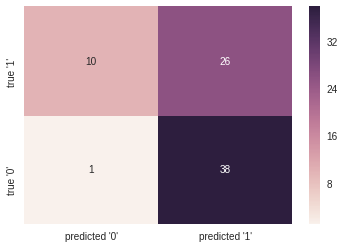

In [28]:
pred = svc.predict(X_ts)
confusion = confusion_matrix(y_ts, pred)

kernel_p=plt.figure()
figsize=(5, 5)
sns.heatmap(confusion, annot=True, fmt="d")
plt.xticks([.5, 1.5], ["predicted '0'", "predicted '1'"], size=10)
plt.yticks([.5, 1.5], ["true '0'", "true '1'"], size=10)
plt.show()

## 교차 검증과 그리드 탐색을 이용한 모형 선택

교차 검증(cross-validation)은 훈련 단계에서 테스트 자료에 대한 예측 성능이 어느 정도인지를 평가하는 방법이다.
그러기 위해 훈련 단계에서 테스트 자료와 유사한 성질을 가진 검증 자료(validation data)
를 운영하는 것이다.

이런 교차 검증은 여러 모형의 예측 성능을 비교하여 최적 모형을 선택할 때 테스트 자료를 사용하지 않고 예측 성능을 비교할 수 있게 해준다.

![kfold](http://www.ds100.org/sp17/assets/notebooks/linear_regression/train_test_split.png)

교차 검증을 할 때 훈련 자료를 등분하는 방법을 지정할 수 있다.
분류 문제의 경우 가장 기본적인 방법을 Stratified K-Fold이다.

In [0]:
kfold = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE)

## 그리드 탐색

그리드 탐색을 위해서는 사용하는 알고리즘의 여러  hyper parameter 중에서 값을 변경할 parameter 이름이 key이고 이 parameter에 지정할 값들을 저장한 list를 value로 하는 dictionary 객체를 만들어야 한다.

다음은 SVC 알고리즘의 `kernel`, `gamma` parameter를 변경하기 위한 사전 객체를 생성하는 예이다.

In [0]:
from sklearn.model_selection import GridSearchCV

params = {'kernel':['poly','sigmoid','rbf'],
          'gamma':[0.0001, 0.001,0.01, 0.05, 0.07, 0.1,0.5]}

다음은 그리드 탐색을 실시하는 예이다.

In [0]:
grid = GridSearchCV(SVC(), params, cv=kfold)

In [32]:
grid.fit(X_tr,y_tr)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=False),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['poly', 'sigmoid', 'rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.05, 0.07, 0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

앞선 모델보다 정확도가 17% 정도 개선된 SVC 모형을 얻었다.


In [33]:
grid.score(X_ts, y_ts)

0.8133333333333334

## 선택된 최적 SVC 모형을 확인할 수 있다.

In [34]:
grid.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

최적 모형을 성능을 좀 더 세밀하게 검토한다.

In [0]:
pred = grid.predict(X_ts)
confusion = confusion_matrix(y_ts, pred)

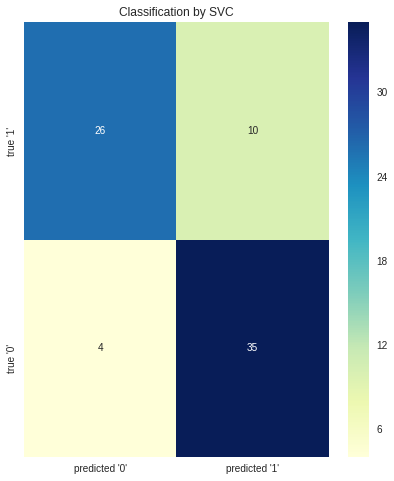

In [36]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
sns.heatmap(confusion, annot=True, fmt="d",cmap="YlGnBu")
plt.xticks([.5, 1.5], ["predicted '0'", "predicted '1'"], size=10)
plt.yticks([.5, 1.5], ["true '0'", "true '1'"], size=10)
plt.title('Classification by SVC')
plt.show()